In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

from IPython.display import SVG

TensorFlow 梯度函数
=========

版本信息：remotes/upstream/r1.8
```
~/W/g/t/t/cc ❯❯❯ git log -n 1                                                      
commit 8753e2ebde6c58b56675cc19ab7ff83072824a62 (HEAD, upstream/r1.8)
Author: Yifei Feng <1192265+yifeif@users.noreply.github.com>
Date:   Fri Apr 27 17:05:02 2018 -0700

    Fixing the mock import error for devel docker. (#18940)

    * Fixing the mock import error for devel docker.

    Same as #18843
```

### 0 常见位置


梯度函数在Python侧和C++侧，均有独立的注册机制。

+ 对于Python侧，一般在 `tensorflow/python/ops/*_grad.py`。

+ 对于C++侧，有两个独立的注册位置：
  - `cc/gradients/*_grad.cc`: 这里是和python对应的移植实现，层级简单。
  - `core/ops/*_grad.cc`: 这里似乎是为Function准备的，我对它了解不多，层级很复杂，目前似乎是实验状态，暂不讲，以后清晰了再说。    
     注: 这个接口有意思的地方是，它的输入输出是强类型，挺好。


下面我画了个简单的类层级关系，用`AbsGrad`梯度为例，有些地方不严谨，作示意导航用。

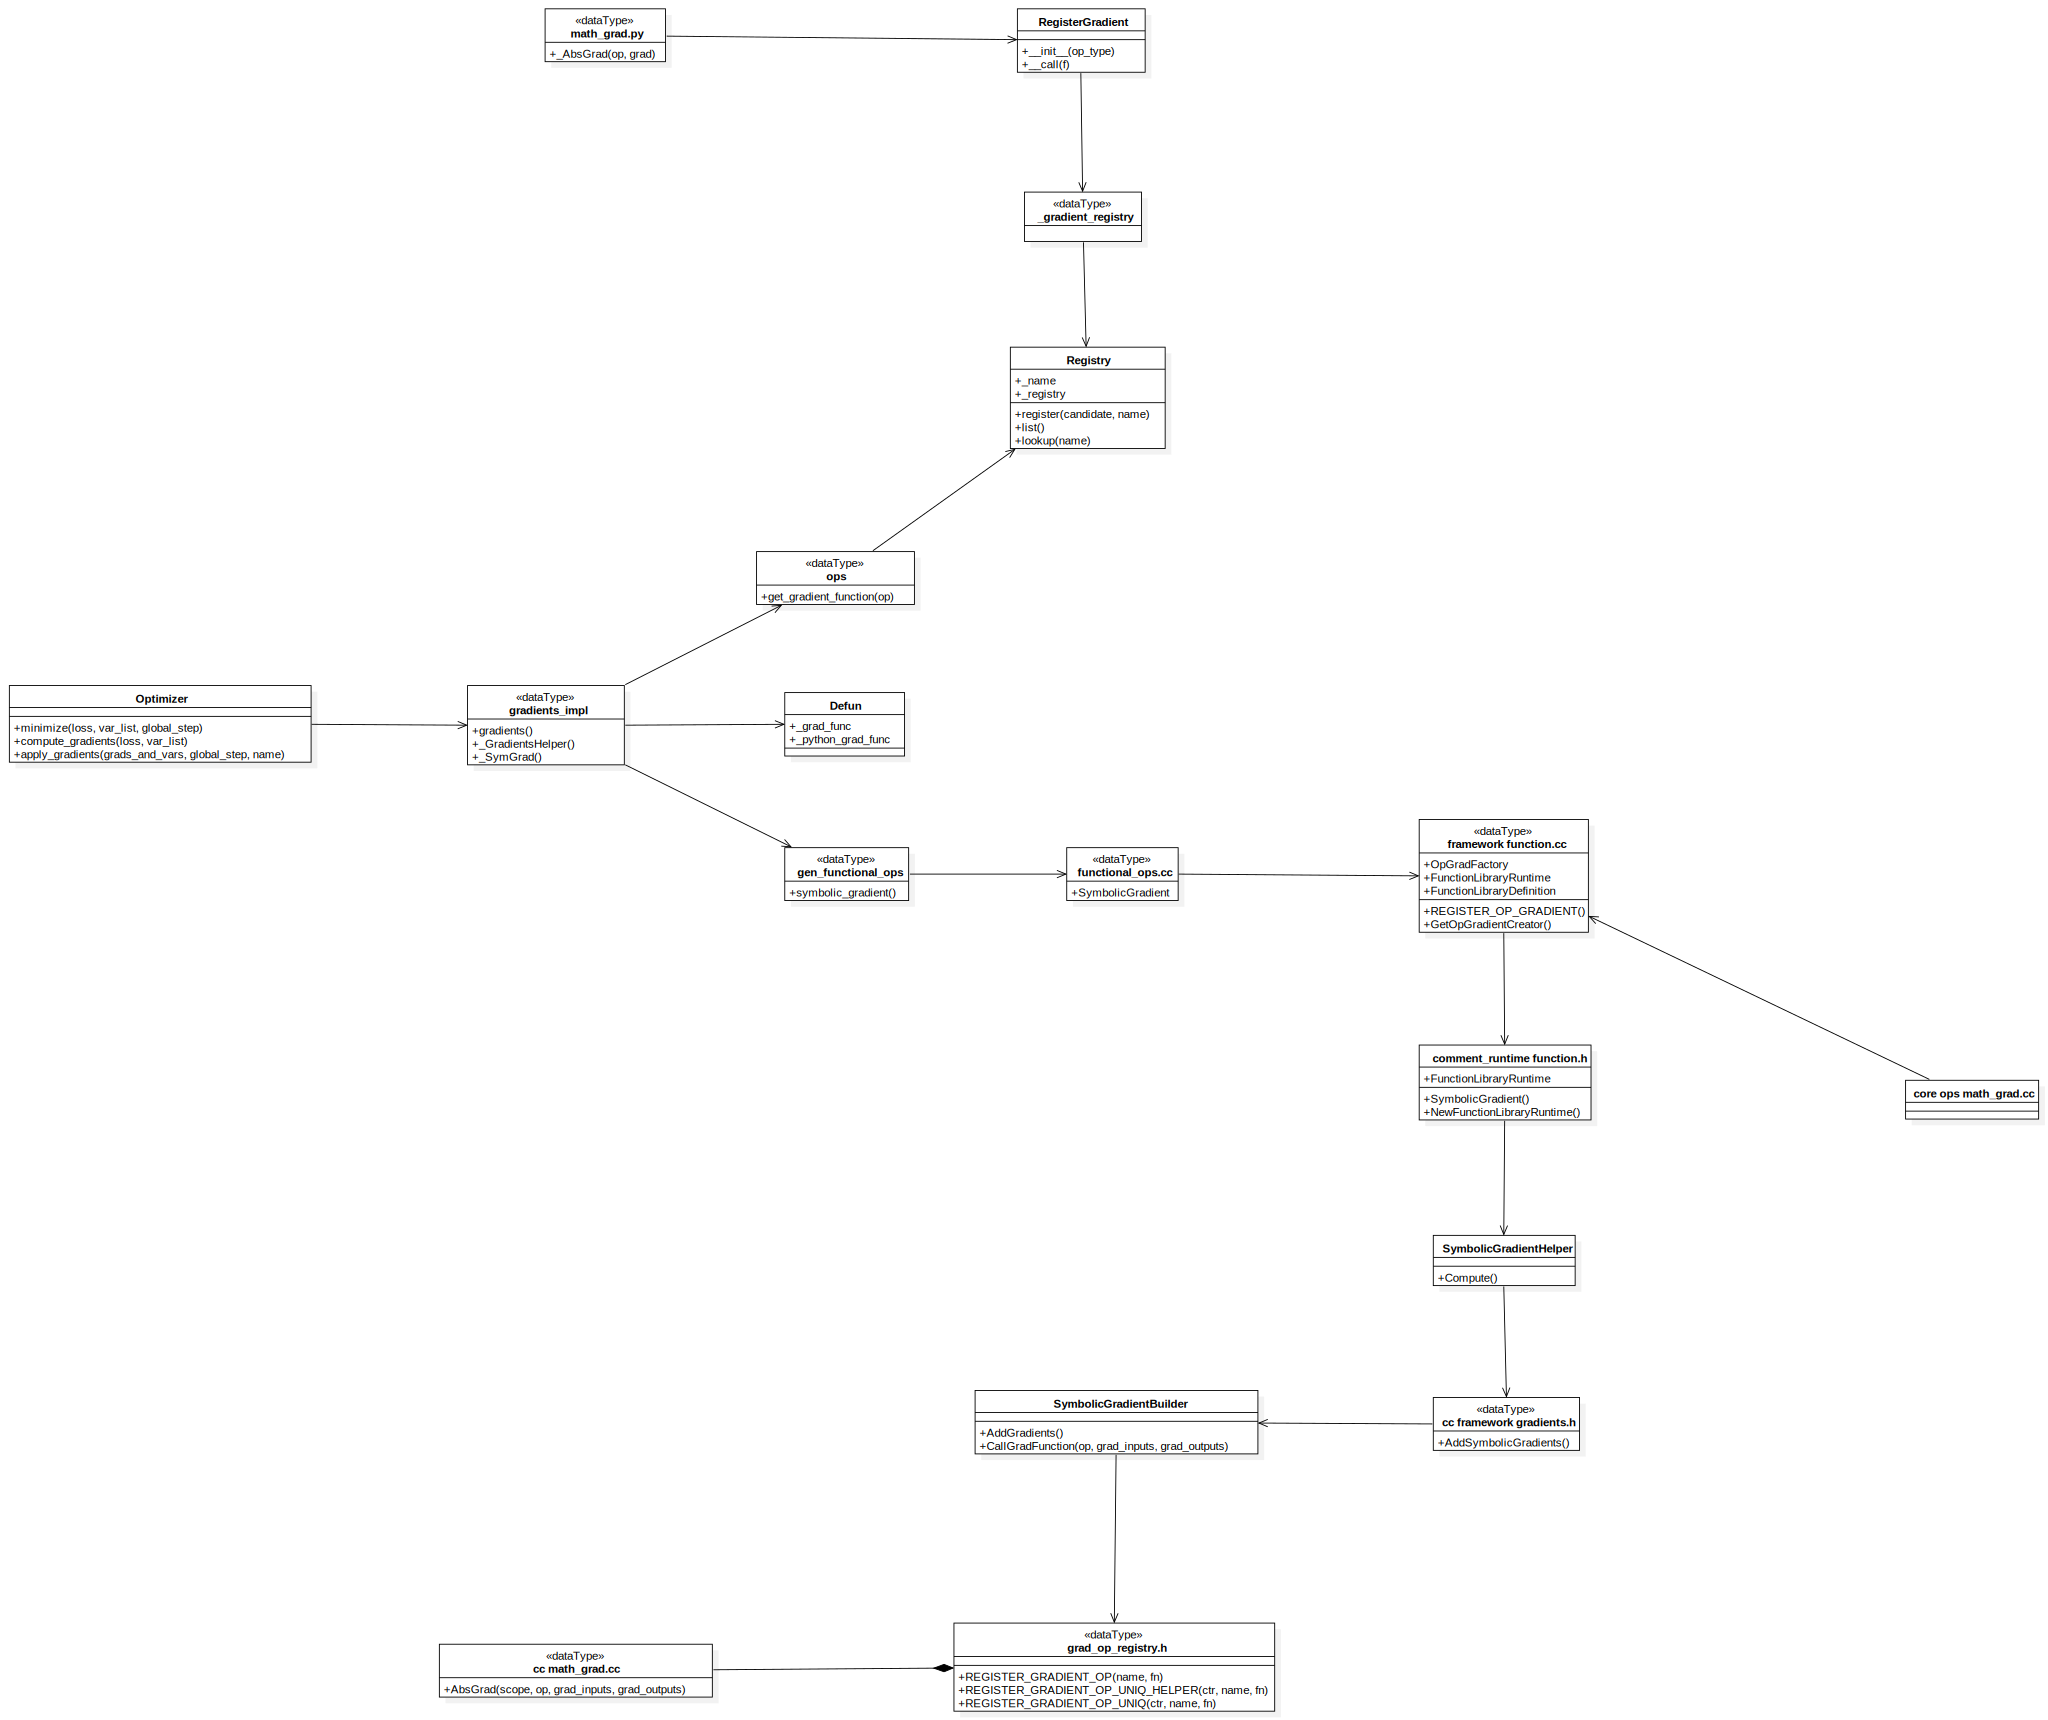

In [2]:
SVG('./res/tf_gradients.svg')

我们一般是在python端调用`tf.gradients`显式计算梯度。这个方法会从子图的末端算子往前回溯，并同时查询每个算子注册的梯度，串接起来。所以，在TensorFlow中，使用的都是解析梯度，而只有在梯度单元测试中，才会用数值梯度来做校验。详细说明可见[does-tensorflow-use-automatic-or-symbolic-gradients](https://stackoverflow.com/questions/36370129/does-tensorflow-use-automatic-or-symbolic-gradients)

### 1 如何写Gradient函数

官方有说明文档，见 [Implement the gradient in Python](https://www.tensorflow.org/extend/adding_an_op#implement_the_gradient_in_pythoN) 。这里就不赘述，举几个实际例子方便理解。

##### 1.1 SquareGrad

第一类是最常见的实现形式，在Python和C++各自独立实现同样逻辑。

以平方算子为例，$y = x ^ 2$，它的梯度是$dy / dx = 2x$。反向传播时要带上后级梯度，所以结果是$dL / dx = \text{grad} * 2 x$。

+ Python侧代码如下：

    ```python
    @ops.RegisterGradient("Square")
    def _SquareGrad(op, grad):
      x = op.inputs[0]
      # Added control dependencies to prevent 2*x from being computed too early.
      with ops.control_dependencies([grad]):
        x = math_ops.conj(x)
        y = constant_op.constant(2.0, dtype=x.dtype)
        return math_ops.multiply(grad, math_ops.multiply(x, y))
    ```

+ C++侧代码如下：

    ```cpp
    Status SquareGrad(const Scope& scope, const Operation& op,
                      const std::vector<Output>& grad_inputs,
                      std::vector<Output>* grad_outputs) {
      // dy/dx = (2 * x)
      auto two = Cast(scope, Const(scope, 2), op.input(0).type());
      auto dydx = Mul(scope, two, op.input(0));
      // grad(x) = grad(y) * conj(dy/dx)
      grad_outputs->push_back(
          Mul(scope, grad_inputs[0], ConjugateHelper(scope, dydx)));
      return scope.status();
    }
    REGISTER_GRADIENT_OP("Square", SquareGrad);
    ```
    
    附上些简要说明： 
    + `op.input`和`op.output`是`Square`输入x和输出y = x^2。
    + `grad_inputs[0]`是反向传导的后级导数`dy`，其实是`dL/dy`的简写。
    + 这个函数要计算`dx`，是`dy/dx`的简写, 结果是2 x。
    + 返回结果写入`grad_outputs`里，`dL/dx = dL/dy * dy/dx`。

    如果输入有多个`x = (x0, x1, ..., xn)`，要分别算对应的导数`[dL/dx0, dL/dx1, ... dL/dxn]`。


代码比较简单，唯一会让人困惑的点，可能是我们如何知道`op.input`, `op.output`和`grad_inputs`各自对应的具体参数，下面细说下。

##### 关于`op.input`和`op.output`

其实这里输入输出对应的是算子的c++接口定义，一般我们可以在它的API定义(core/api_def/base_api/*.pbtxt)或者算子注册文件(core/ops/*.cc)里找到定义。更简单的方法，是调用程序，直接输出算子的定义，如下：

```python
In [28]: b = tf.square(a)     

In [29]: b.op.op_def
Out[29]:
name: "Square"
input_arg {
  name: "x"
  type_attr: "T"
}
output_arg {
  name: "y"
  type_attr: "T"
}
attr {
  name: "T"
  type: "type"
  allowed_values {
    list {
      type: DT_HALF
      type: DT_BFLOAT16
      type: DT_FLOAT
      type: DT_DOUBLE
      type: DT_INT32
      type: DT_INT64
      type: DT_COMPLEX64
      type: DT_COMPLEX128
    }
  }
}
```

我们可以看到，对于Square算子，它只有一个输入$x$，和一个输出$y$，所以它的`op.input(0) = x`, `op.output(0) = y`。


##### 关于`grad_inputs`

这里其实是对应于后级输出`op.output`，有几个输出，每个输出就有一个梯度返回。对于Square算子，它只有一个输出，所以也只有一个`grad_inputs(0) = dL / dy`。

##### 1.2 SqrtGrad

第二类梯度是为了运算效率加速，把梯度本身实现成一个单独的算子，然后在C++和Python端调用同样的底层算子。

以开方为例，$y = \sqrt(x)$，它的梯度是$dy / dx = \frac1{2} x ^{- \frac1{2}} = 0.5 / y$。所以完整结果是$dL / dx = 0.5 * \text{grad} / y$。

这个算子首先在eigen名字空间下实现了梯度逻辑的kernel：
```bash
/core/kernels/cwise_ops.h: 含有Eigen扩展：functor和numext
/core/kernels/cwise_ops_gradients.h: 导数
/core/kernels/cwise_op_sqrt.cc: 注册核函数
```

```cpp
// Gradient for the sqrt function
template <typename T>
struct scalar_sqrt_gradient_op {
  EIGEN_EMPTY_STRUCT_CTOR(scalar_sqrt_gradient_op)
  EIGEN_DEVICE_FUNC EIGEN_STRONG_INLINE const T
  operator()(const T& output, const T& output_gradient) const {
    const T out_conj = numext::conj(output);
    return static_cast<T>(0.5) * output_gradient / out_conj;
  }
  template <typename Packet>
  EIGEN_DEVICE_FUNC EIGEN_STRONG_INLINE const Packet
  packetOp(const Packet& output, const Packet& output_gradient) const {
    const Packet const_half = pset1<Packet>(static_cast<T>(0.5));
    const Packet out_conj = pconj(output);
    return pdiv(pmul(const_half, output_gradient), out_conj);
  }
};
```

然后在`/core/ops/math_ops.cc`下注册接口：

```cpp
REGISTER_OP("SqrtGrad").UNARY_GRADIENT_COMPLEX();
```

接下来在梯度注册代码处，调用这个算子就可以：

+ Python端调用
    ```python
    @ops.RegisterGradient("Sqrt")
    def _SqrtGrad(op, grad):
      y = op.outputs[0]  # y = x^(1/2)
      return gen_math_ops.sqrt_grad(y, grad)
    ```
  
+ C++端调用

    ```cpp
    Status SqrtGrad(const Scope& scope, const Operation& op,
                    const std::vector<Output>& grad_inputs,
                    std::vector<Output>* grad_outputs) {
      // Use the built-in operator.
      grad_outputs->push_back(
          internal::SqrtGrad(scope, op.output(0), grad_inputs[0]));
      return scope.status();
    }
    REGISTER_GRADIENT_OP("Sqrt", SqrtGrad);
    ```


##### 1.2 SqrtGradGrad

第三类是一些名字如`xxxGradGrad`的梯度算子。因为反向传播是利用的一阶导的链式法式，我们应该把它单纯当作是`xxxGrad`公式展开的一阶导，而不要把它视为`xxx`的二阶导，否则会带来很多困惑。

以`SqrtGradGrad`算子为例，它旳实际计算式是$dy = 0.5 * \text{grad} / y$，有两个输入grad和$y$，所以它有两个导数：

为了和代码符号一致，我们改写实际计算式为$y = 0.5 * b / a$：

\begin{align}
    dL / da &= \text{grad} * 0.5 * b * -1 * a^{-2} \\
            &= - \text{grad} * 0.5 * b * / a / a \\
            &= - \text{grad} * y / a \\
            &= - \text{grad} / a * y \\
            &= - \text{ga} * y \\
    dL / db &= \text{grad} * 0.5 / a \\
            &= 0.5 * \text{ga} \\
\end{align}

所以Python侧实现代码是：

```python
@ops.RegisterGradient("SqrtGrad")
def _SqrtGradGrad(op, grad):
  a = op.inputs[0]
  y = op.outputs[0]  # y = 0.5 * b / conj(a)
  with ops.control_dependencies([grad]):
    ga = grad / a
    return -math_ops.conj(ga) * y, 0.5 * ga
```

强调，实际计算式一定是和具体实现对应的，要把`xxxGrad`理解成一个算子，它有实际输入和输出，而不要把它认为是`xxx`的附属。

### 2 小结

本文简要介绍了TensorFlow的梯度相关架构，并给出几个具体梯度实现的分析例子。